In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Read NHL_ALL file
ALL = pd.read_csv('NHL_ALL.csv')  

# Drop playoff games from calculations.
NHL_ALL = ALL.query("situation == 'all' and playoffGame == 0 and season != 2012 and season != 2020")

In [52]:
# Append season to team name columns.
NHL_ALL.loc[:, "playerTeam"] = NHL_ALL["playerTeam"] + "_" + NHL_ALL["season"].astype(str)
NHL_ALL.loc[:, "opposingTeam"] = NHL_ALL["opposingTeam"] + "_" + NHL_ALL["season"].astype(str)

C:\Users\crist\AppData\Local\Temp\ipykernel_18872\971560010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NHL_ALL.loc[:, "playerTeam"] = NHL_ALL["playerTeam"] + "_" + NHL_ALL["season"].astype(str)
C:\Users\crist\AppData\Local\Temp\ipykernel_18872\971560010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NHL_ALL.loc[:, "opposingTeam"] = NHL_ALL["opposingTeam"] + "_" + NHL_ALL["season"].astype(str)


In [53]:
# Take necessary columns/discard auxillary data
NHL_ALL = pd.DataFrame(NHL_ALL[["season", "playerTeam", "opposingTeam", "gameId", "goalsFor", "goalsAgainst"]]).set_index("gameId")

# Create list of teams/season
TEAMS_ALL = NHL_ALL["playerTeam"].unique()

# Create list of dataframes for each season 2008-2022
# Discard 2012 and 2020 seasons because of lockout
seasons = []
for year in range(2008,2023):
    if (year != 2012 and year != 2020):
        seasons.append(NHL_ALL.query("season == @year"))




In [75]:
# Use scipy.optimize.fsolve to solve nonlinear system
from scipy import optimize

# NO_GAMES_ALL = pd.DataFrame(np.zeros([len(TEAMS_ALL), len(TEAMS_ALL)]), columns=[TEAMS_ALL], index=[TEAMS_ALL])
# Create arrays to hold offensive strengths and defensive vulnerabilities for teams/season
O_S_ALL = []
D_V_ALL = []

# Solve non-linear system for each season
for year in seasons:
    # List of teams in season
    teams_season = year["playerTeam"].unique()
    # Create table array of number of games between teams
    NO_GAMES = pd.DataFrame(np.zeros([len(teams_season), len(teams_season)]), columns=[teams_season], index=[teams_season])
    # Iterate through year dataframe and count games into NO_GAMES
    for index, game in year.iterrows():
        Team = game["playerTeam"]
        Opp = game["opposingTeam"]
        NO_GAMES.loc[Team,Opp] += 1
    # Convert num of games to int values
    NO_GAMES = NO_GAMES.astype(int)

    # Declare variables for matrices
    P = NO_GAMES.to_numpy()
    zeroMat = np.zeros((len(teams_season), len(teams_season)))
    f = year.groupby(['playerTeam'])['goalsFor'].sum().to_numpy() # goals for
    c = year.groupby(['playerTeam'])['goalsAgainst'].sum().to_numpy() # goals conceded

    # Define function to obtain x vector
    def func(x):
        return(np.matmul(np.transpose(x), np.block([[zeroMat, P],[np.transpose(P), zeroMat]]))*x  - np.transpose(np.hstack((f,c))))
    # Call function to get vector of O and V
    x = np.transpose(np.hstack((f/sum(f),c/sum(c))))
    while sum(func(x))**2 > 0.001:
        x = optimize.fsolve(func, x)
    # x includes both offensive strengths and defensive vulnerabilities
    # Split it up
    Offensive_Strength = x[0:int((len(x))/2)]
    Defensive_Vulnerability = x[int((len(x))/2):]

    # Normalize V
    # Append season to array holding all seasons
    O_S_ALL.append(Offensive_Strength)
    D_V_ALL.append(Defensive_Vulnerability)

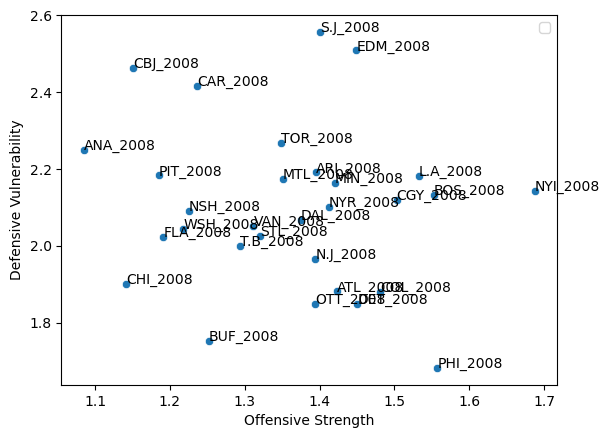

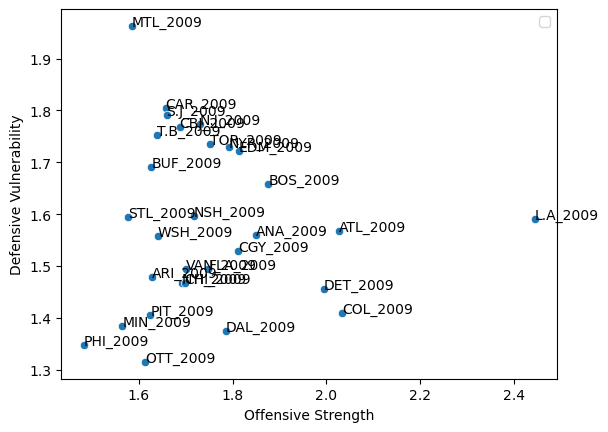

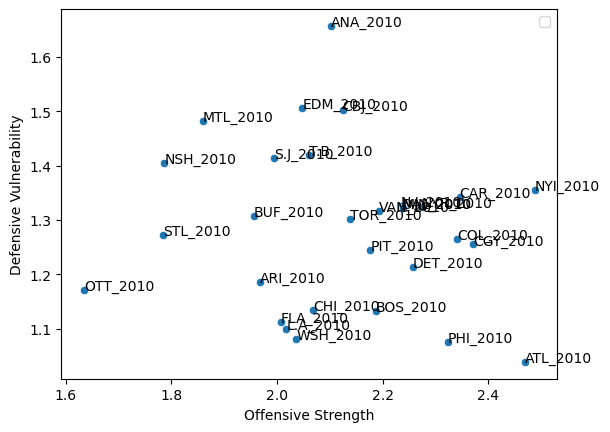

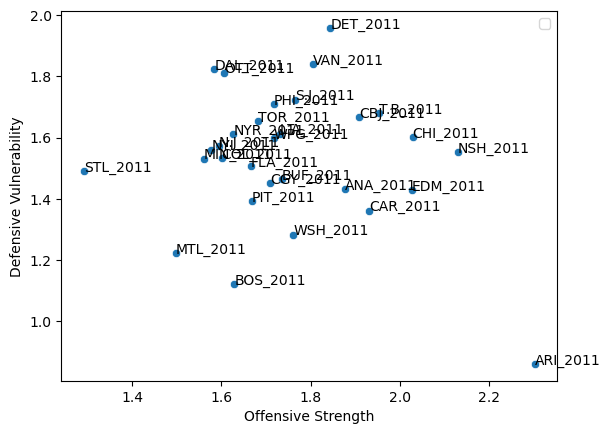

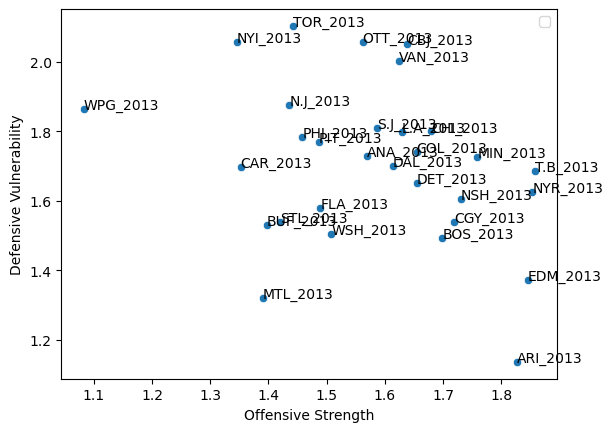

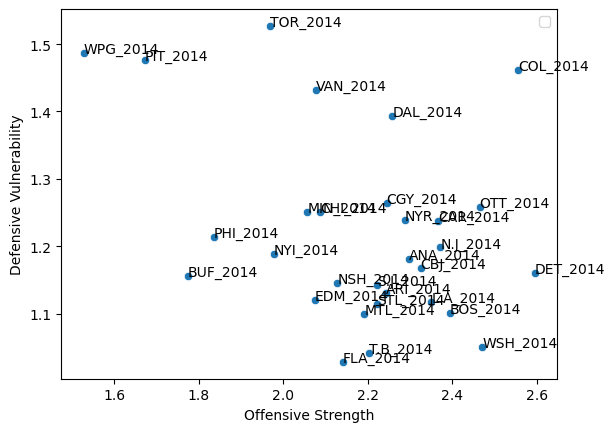

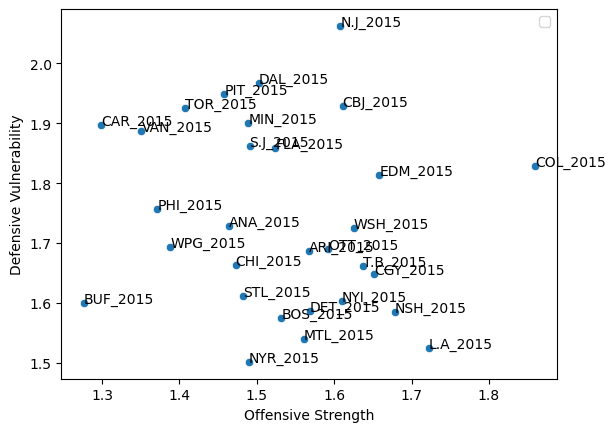

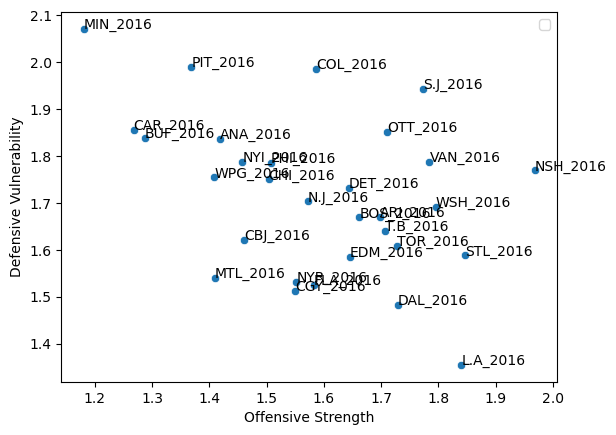

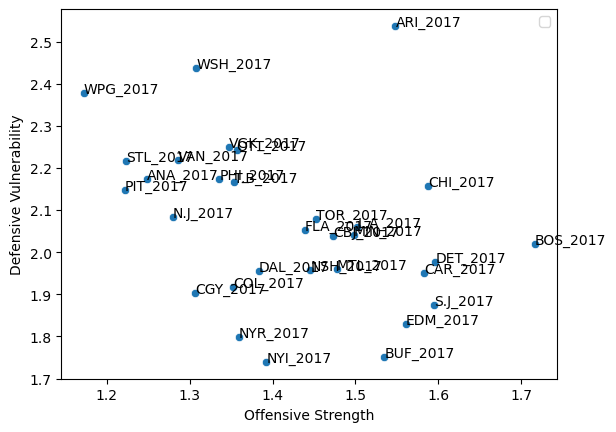

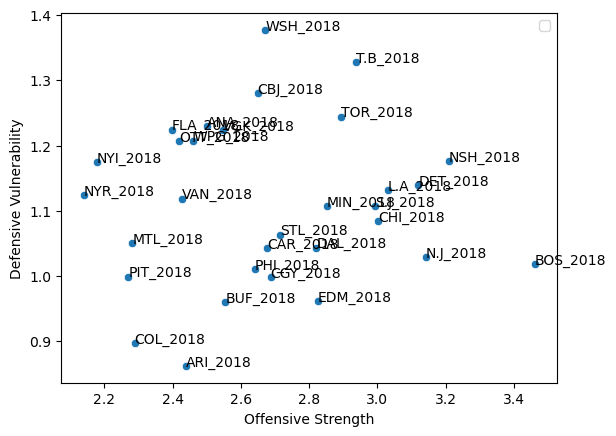

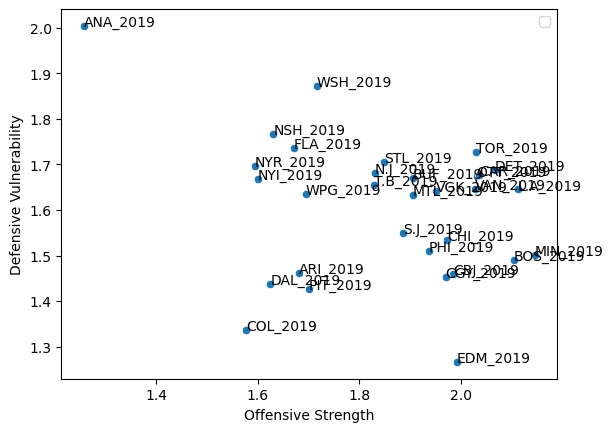

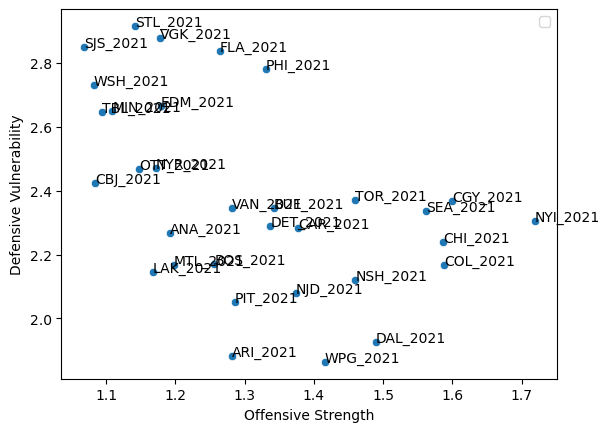

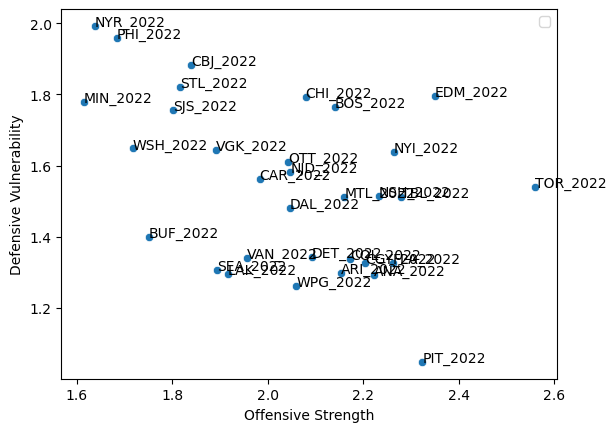

In [78]:
import seaborn as sns

for i, year in enumerate(seasons):
    ax = sns.scatterplot(
        data = year["playerTeam"].unique(),
        x = O_S_ALL[i],
        y = D_V_ALL[i], 
    )
    # Label points.
    for j, team in enumerate(year["playerTeam"].unique()):
        ax.text(O_S_ALL[i][j],
                D_V_ALL[i][j],
                team,)
        
    plt.xlabel("Offensive Strength")
    plt.ylabel("Defensive Vulnerability")
    plt.legend([])
    plt.show()

In [94]:
r = []
for (O_season, V_season, year) in zip(O_S_ALL, D_V_ALL, seasons):
    r_season = []
    for (O,V, team) in zip(O_season, V_season, year["playerTeam"].unique()):
        r_season.append((O/V, team))
    r.append(r_season)

for R in r:
    R.sort()
    i = 1
    # Table header.
    print("SEASON: %s" %(R[0][1][4:]))
    print(" RANK \t| TEAM")
    print("++++++++++++++++++++++")
    # Print ranking with team name
    for TeamRank in R:
        print(" %d \t| %s " %(i, TeamRank[1]))
        i += 1
    print("\n \n")


SEASON: 2008
 RANK 	| TEAM
++++++++++++++++++++++
 1 	| CBJ_2008 
 2 	| ANA_2008 
 3 	| CAR_2008 
 4 	| PIT_2008 
 5 	| S.J_2008 
 6 	| EDM_2008 
 7 	| NSH_2008 
 8 	| FLA_2008 
 9 	| TOR_2008 
 10 	| WSH_2008 
 11 	| CHI_2008 
 12 	| MTL_2008 
 13 	| ARI_2008 
 14 	| VAN_2008 
 15 	| T.B_2008 
 16 	| STL_2008 
 17 	| MIN_2008 
 18 	| DAL_2008 
 19 	| NYR_2008 
 20 	| L.A_2008 
 21 	| CGY_2008 
 22 	| N.J_2008 
 23 	| BUF_2008 
 24 	| BOS_2008 
 25 	| OTT_2008 
 26 	| ATL_2008 
 27 	| DET_2008 
 28 	| NYI_2008 
 29 	| COL_2008 
 30 	| PHI_2008 

 

SEASON: 2009
 RANK 	| TEAM
++++++++++++++++++++++
 1 	| MTL_2009 
 2 	| CAR_2009 
 3 	| S.J_2009 
 4 	| T.B_2009 
 5 	| CBJ_2009 
 6 	| BUF_2009 
 7 	| N.J_2009 
 8 	| STL_2009 
 9 	| TOR_2009 
 10 	| NYR_2009 
 11 	| WSH_2009 
 12 	| EDM_2009 
 13 	| NSH_2009 
 14 	| PHI_2009 
 15 	| ARI_2009 
 16 	| MIN_2009 
 17 	| BOS_2009 
 18 	| VAN_2009 
 19 	| NYI_2009 
 20 	| PIT_2009 
 21 	| CHI_2009 
 22 	| FLA_2009 
 23 	| ANA_2009 
 24 	| CGY_20